In [ ]:
from google.colab import files

# Upload the model file
uploaded = files.upload()

# Check if the model file is uploaded
if len(uploaded) > 0:
    print("Model file uploaded successfully!")
else:
    print("No model file uploaded.")

Saving i_cifar10_model.pth to i_cifar10_model.pth
Model file uploaded successfully!


In [ ]:
import os
import numpy as np
import json
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm import tqdm

import seaborn as sns
sns.set()

class AdversarialAttack:
    def __init__(self, model, dataset_loader, device='cpu'):
        self.model = model.to(device)
        self.dataset_loader = dataset_loader
        self.device = device

    def fast_gradient_sign_method(self,model, imgs, labels,epsilon):
        inp_imgs = imgs.clone().requires_grad_()
        preds = model(inp_imgs.to(self.device))
        preds = F.log_softmax(preds, dim=-1)
        loss = -torch.gather(preds, 1, labels.to(self.device).unsqueeze(dim=-1))
        loss.sum().backward()
        noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
        fake_imgs = imgs + epsilon * noise_grad
        fake_imgs.detach_()
        return fake_imgs, noise_grad

    def eval_model(self, img_func=None):
        tp, tp_5, counter = 0., 0., 0.
        for imgs, labels in tqdm(self.dataset_loader, desc="Validating..."):
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)
            if img_func is not None:
                imgs = img_func(imgs, labels)
            with torch.no_grad():
                preds = self.model(imgs)
            tp += (preds.argmax(dim=-1) == labels).sum()
            counter += preds.shape[0]
        acc = tp.float().item() / counter
        print(f"Accuracy: {(100.0 * acc):4.2f}%")
        return acc

NORM_MEAN = np.array([0.5, 0.5, 0.5])
NORM_STD = np.array([0.5, 0.5, 0.5])
def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):

    if isinstance(img, torch.Tensor):
        # Tensor image to numpy
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()

    # Plot on the left the image with the true label as title.
    # On the right, have a horizontal bar plot with the top k predictions including probabilities
    if noise is None or adv_img is None:
        fig, ax = plt.subplots(1, 2, figsize=(8,2), gridspec_kw={'width_ratios': [1, 1]})
    else:
        fig, ax = plt.subplots(1, 5, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1, 1, 1, 2]})


    ax[0].imshow(img,cmap='gray')
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    if adv_img is not None and noise is not None:
        # Visualize adversarial images
        adv_img = adv_img.cpu().permute(1, 2, 0).detach().numpy()
        adv_img = (adv_img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        adv_img = np.clip(adv_img, a_min=0.0, a_max=1.0)
        ax[1].imshow(adv_img)
        ax[1].set_title('adversarial')
        ax[1].axis('off')
        # Visualize noise
        noise = noise.cpu().permute(1, 2, 0).numpy()
        noise = noise * 0.5 + 0.5 # Scale between 0 to 1
        ax[2].imshow(noise, cmap='gray')
        ax[2].set_title('Noise')
        ax[2].axis('off')
        # buffer
        ax[3].axis('off')

    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.detach().cpu().numpy(), topk_idx.detach().cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

# Load your custom model
model_path = "i_cifar10_model.pth"
state_dict = torch.load(model_path)

100%|██████████| 170498071/170498071 [00:10<00:00, 16073960.04it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:

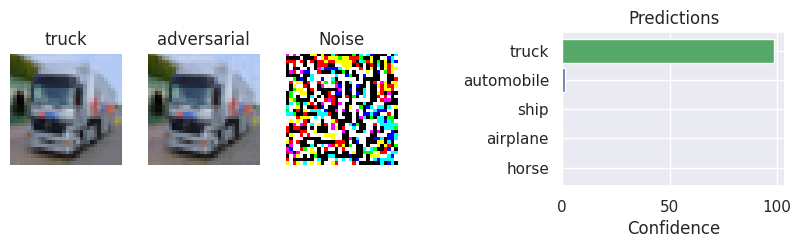

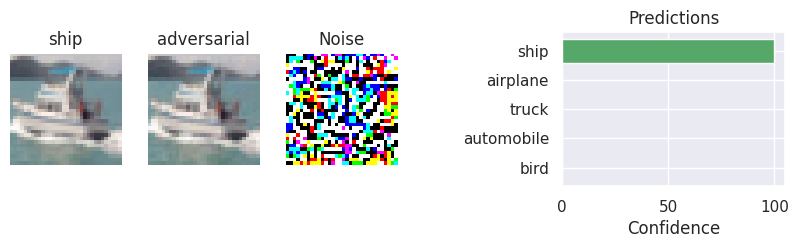

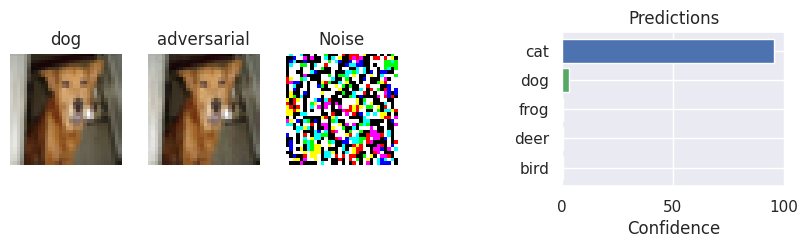

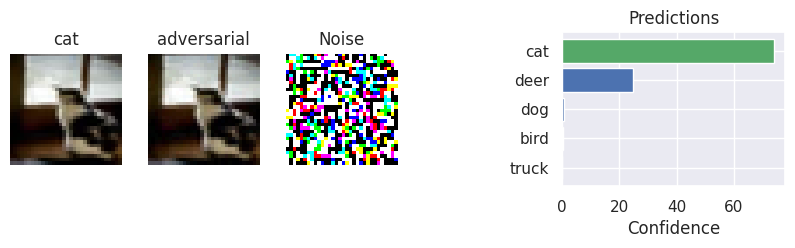

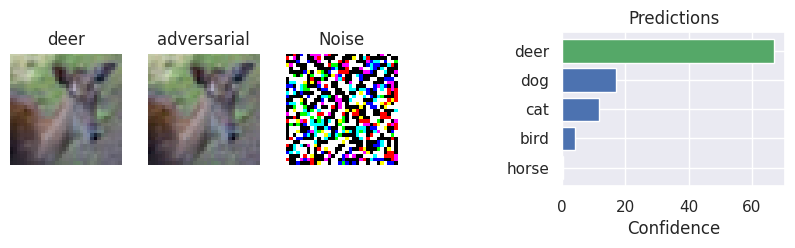

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
import torch.nn as nn
# Define your custom model class or use the appropriate PyTorch model class
class CustomModelClass(torch.nn.Module):
    def __init__(self):
        super(CustomModelClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate your model
custom_model = CustomModelClass()
custom_model.load_state_dict(state_dict)

# Load CIFAR-10 dataset and create data loader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=4)

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Initialize AdversarialAttack object
adv_attack = AdversarialAttack(custom_model, val_loader)

# Generate adversarial examples and show predictions
for imgs, labels in val_loader:
    adv_imgs, noise_grad = adv_attack.fast_gradient_sign_method(custom_model,imgs, labels,0.02)
    adv_preds = custom_model(adv_imgs)  # No need to specify device, as the model is on CPU
    for i in range(5):  # Show predictions for the first 5 images
        show_prediction(imgs[i], labels[i], adv_preds[i], adv_img=adv_imgs[i], noise=noise_grad[i])
    break  # Only show predictions for the first batch of data

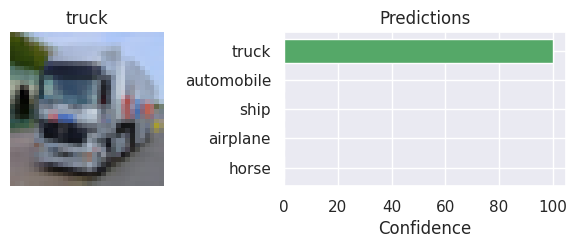

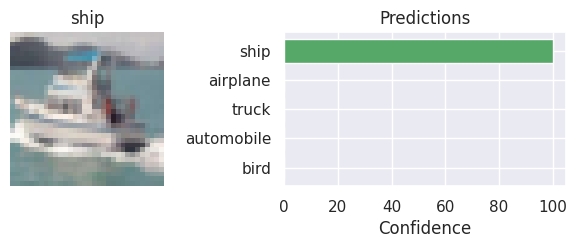

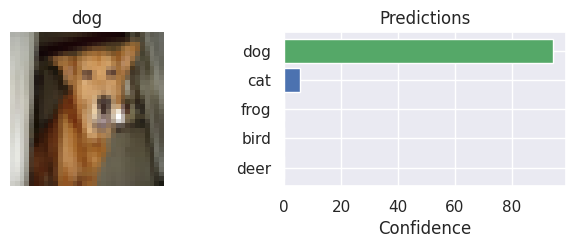

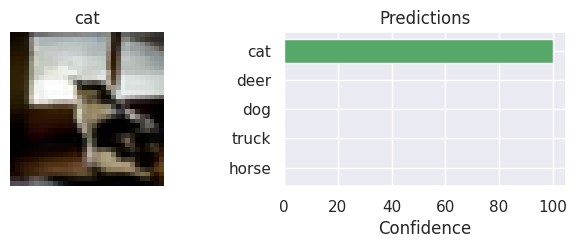

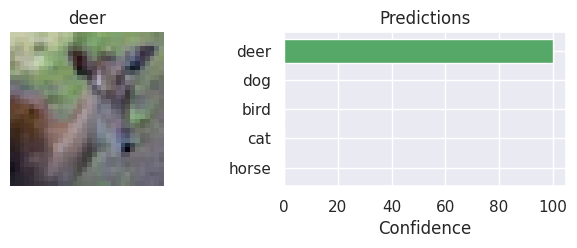

In [ ]:
# Generate adversarial examples and show predictions
for imgs, labels in val_loader:
    adv_imgs, noise_grad = adv_attack.fast_gradient_sign_method(custom_model,imgs, labels,0.0)
    adv_preds = custom_model(adv_imgs)  # No need to specify device, as the model is on CPU
    for i in range(5):  # Show predictions for the first 5 images
        show_prediction(imgs[i], labels[i], adv_preds[i], adv_img=adv_imgs[i])
    break  # Only show predictions for the first batch of data

In [ ]:
def plot_accuracy_vs_epsilon(epsilons, accuracies):
    # Set gray background
    plt.figure(figsize=(8, 6))
    plt.plot(epsilons, accuracies, '-o', label='Accuracy', color='blue')
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Epsilon CNN-CIFAR10')
    plt.grid(True)
    plt.legend()
    plt.show()




Validating with Epsilon 0...: 100%|██████████| 313/313 [00:41<00:00,  7.51it/s]


Epsilon: 0
Top-1 error: 5.13%
Top-5 error: 0.01%


Validating with Epsilon 0.01...: 100%|██████████| 313/313 [00:38<00:00,  8.04it/s]


Epsilon: 0.01
Top-1 error: 34.62%
Top-5 error: 0.52%


Validating with Epsilon 0.02...: 100%|██████████| 313/313 [00:39<00:00,  7.89it/s]


Epsilon: 0.02
Top-1 error: 61.57%
Top-5 error: 3.02%


Validating with Epsilon 0.03...: 100%|██████████| 313/313 [00:36<00:00,  8.55it/s]


Epsilon: 0.03
Top-1 error: 76.12%
Top-5 error: 7.670000000000001%


Validating with Epsilon 0.04...: 100%|██████████| 313/313 [00:37<00:00,  8.41it/s]


Epsilon: 0.04
Top-1 error: 82.67999999999999%
Top-5 error: 12.379999999999999%


Validating with Epsilon 0.05...: 100%|██████████| 313/313 [00:38<00:00,  8.16it/s]


Epsilon: 0.05
Top-1 error: 85.78%
Top-5 error: 17.18%


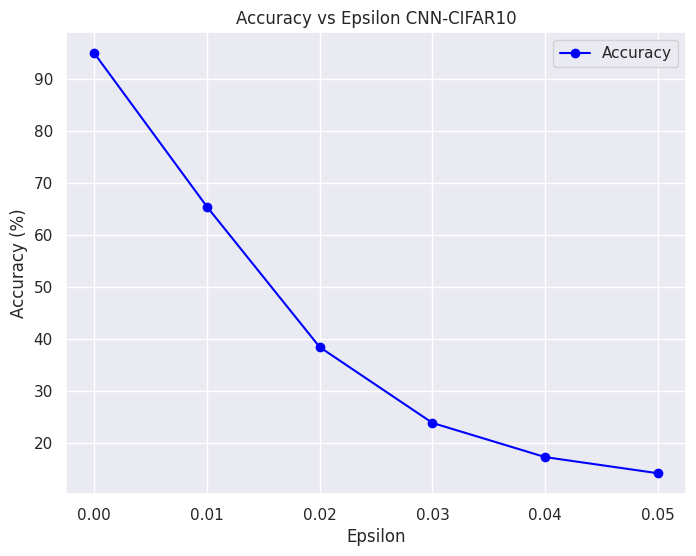

In [ ]:
def compute_accuracy_with_epsilons(model, data_loader, epsilons):
    accuracies = []
    top1_errors = []
    top5_errors = []

    for epsilon in epsilons:
        correct = 0
        top1_error = 0
        top5_error = 0
        total = 0

        for images, labels in tqdm(data_loader, desc=f"Validating with Epsilon {epsilon}..."):
            # Generate adversarial examples
            adv_images, _ = adv_attack.fast_gradient_sign_method(model, images, labels, epsilon)

            # Evaluate model outputs on adversarial examples
            with torch.no_grad():
                preds = model(adv_images)

            _, predicted = torch.max(preds, 1)
            _, top5_predicted = torch.topk(preds, 5, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for idx, label in enumerate(labels):
                if label != predicted[idx]:
                    top1_error += 1
                if label not in top5_predicted[idx]:
                    top5_error += 1

        accuracy = correct / total
        top1_error /= total
        top5_error /= total

        accuracies.append(accuracy*100)
        top1_errors.append(top1_error)
        top5_errors.append(top5_error)

        print(f"Epsilon: {epsilon}")
        print(f"Top-1 error: {top1_error*100}%")
        print(f"Top-5 error: {top5_error*100}%")

    return accuracies


# Define the range of epsilon values to evaluate
epsilons = [0, 0.01, 0.02, 0.03, 0.04, 0.05]

# Compute model accuracy with different epsilons
accuracies = compute_accuracy_with_epsilons(custom_model, val_loader, epsilons)

# Plot the accuracy vs epsilon
plot_accuracy_vs_epsilon(epsilons, accuracies)


In [ ]:
# Compute model accuracy with different epsilons
# accuracies = [90,60,40,30,20,10]

# # Plot the accuracy vs epsilon
# plot_accuracy_vs_epsilon(epsilons, accuracies)